In [ ]:
#| default_exp diffusion_walks

# Libs

In [169]:
#| export
import numpy as np
from tqdm.notebook import tqdm, trange
from tqdm import tqdm as tqdm_term
from joblib import Parallel, delayed
from rl_optimal_search.environment import isBetween_ab_Vec, target_search_onhit
from typing import Callable
from rl_optimal_search.utils import add_colorbar


In [3]:
#| hide
import matplotlib.pyplot as plt

In [4]:
%load_ext autoreload
%autoreload 2

# Lévy Walks

In [9]:
#| export
def lw_step(beta, num_samples = 1):
    return (1 - np.random.rand(num_samples))**(-1/(beta))

In [208]:
beta = 1
x = np.arange(1, 1000)

num = lw_step(beta, num_samples=1000000)

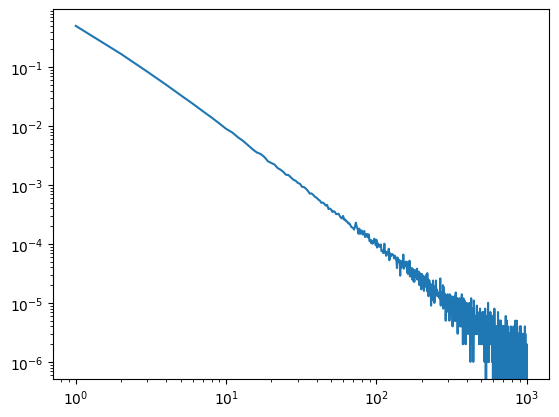

In [212]:
h, e = np.histogram(num, bins = np.linspace(1, 1e3, 1000))
plt.loglog(e[:-1], h/np.sum(h))

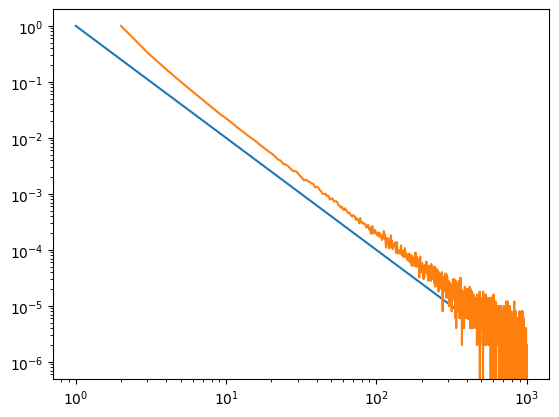

In [602]:
h, e = np.histogram(num, bins = np.linspace(1, 1e3, 1000))

theory = x.astype(float)**(-beta-1)
plt.loglog(x, theory)
plt.loglog(e[1:], h/h[0])


In [10]:
#| export
def lw_trajs(N = 1, T = 100, alpha = 1, L = None, BC = 'reflectant'):
    
    pos = np.zeros((N, T, 2))
    
    if L is None:
        
        angles = np.random.uniform(low = 0, high = 2*np.pi, size = (N, T))
        steps = (1 - np.random.rand(N, T))**(-1/alpha)
        pos[:, :, 0], pos[:, :, 1] = [steps*np.cos(angles), steps*np.sin(angles)] 
   
        return np.cumsum(pos, axis = 1)

    else:
        
        pos = np.zeros((N, T, 2))
        pos[:, 0, :] = np.random.rand(N, 2)*L

        for t in tqdm(range(1, T)):

            angles = np.random.uniform(low = 0, high = 2*np.pi, size = N)
            steps = (1 - np.random.rand(N))**(-1/alpha)
            pos[:, t, 0] = pos[:, t-1, 0] + steps*np.cos(angles)
            pos[:, t, 1] = pos[:, t-1, 1] + steps*np.sin(angles)


        if BC == 'reflectant':
            while np.max(pos[:, t, :])>L or np.min(pos[: ,t, :])< 0: 
                pos[pos > L] = pos[pos > L] - 2*(pos[pos > L] - L)
                pos[pos < 0] = - pos[pos < 0]


        elif BC == 'periodic':
            while np.max(pos[:, t, :])>L or np.min(pos[: ,t, :])< 0: 
                pos[pos > L] = pos[pos > L] - L
                pos[pos < 0] = L + pos[pos < 0]     
        
            
        
        return pos

In [59]:
alpha = 0.5; L = 10000
N = int(1e6); T = int(1e3)

trajs = lw_trajs(N = N, T = T, alpha = alpha, L = L, BC = None)

if L is not None:
#     trajsm  = (trajs.reshape(T, N, 2) - trajs[:, 0, :]).reshape(N, T, 2)
    trajsm  = (trajs[:,:,0].transpose() - trajs[:,0,0]).transpose()


msd = np.mean(trajsm**2, axis= 0)
# msd = np.mean(msd, axis = 1)

  0%|          | 0/999 [00:00<?, ?it/s]

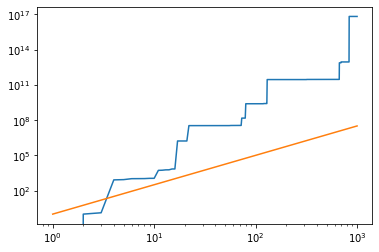

In [60]:
t = np.arange(1, msd.shape[0]+1)
plt.loglog(t, msd/msd[1], label = 'Numerics')
plt.loglog(t, t**(3-alpha))

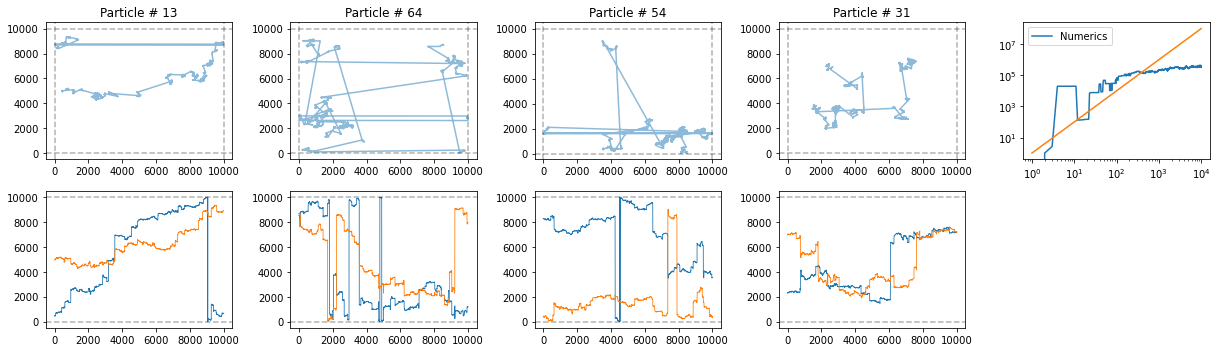

In [289]:
fig, axs = plt.subplots(2, 5, figsize = (17, 5), tight_layout = True)

for ax in axs[:, :-1].transpose():
    part = np.random.randint(N)    
    ax[0].set_title(f'Particle # {part}')
    ax[0].plot(trajs[part, :, 0], trajs[part, :, 1], alpha = 0.5)
    

    ax[1].plot(trajs[part, :, 0], '-', label = 'X', ms = 3, lw = 0.8)
    ax[1].plot(trajs[part, :, 1], '-', label = 'Y', ms = 3, lw = 0.8)

    
    if L is not None:
        ax[0].axhline(L, ls = '--', alpha = 0.3, c = 'k')
        ax[0].axhline(0, ls = '--', alpha = 0.3, c = 'k')
        ax[0].axvline(L, ls = '--', alpha = 0.3, c = 'k')
        ax[0].axvline(0, ls = '--', alpha = 0.3, c = 'k')
        
        ax[1].axhline(L, ls = '--', alpha = 0.3, c = 'k')
        ax[1].axhline(0, ls = '--', alpha = 0.3, c = 'k')

    
t = np.arange(1, msd.shape[0]+1)
axs[0, -1].loglog(t, msd/msd[1], label = 'Numerics')
axs[0, -1].loglog(t, t**(3-alpha))
axs[0, -1].legend()

axs[1, -1].set_axis_off()

## Searching

In [11]:
Nt = 4000
density = 0.01
N = 2000; T = int(100)
L = Nt/density
at = 0.5
ls = 5

In [153]:
target_search_onhit(Nt = Nt, N = N, T = T, alpha = 0.1, L = L, at = at, ls = ls, sample_step = lw_step, num_part = N)

  0%|          | 0/99 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [12]:
alphas = np.linspace(0.1, 2, 8)


results = np.array(Parallel(n_jobs=len(alphas))(delayed(target_search_onhit)(Nt = Nt, N = N, T = T, sample_step = lw_step, alpha = alpha, L = L, at = at, ls = ls)
                for alpha in alphas), dtype = object)

In [8]:
    
encs = results

m_eta = np.zeros(len(alphas))
std_eta = np.zeros_like(m_eta)

for idx_a, e in enumerate(tqdm(encs)):
#     ee = e.copy()
#     ee[ee != 0] = 1
    m_eta[idx_a] = e.flatten().mean()
    std_eta[idx_a] = e.flatten().std()
    

# enc, real_steps = LW_search(Nt = Nt, N = N, T = T, alpha = alpha, L = L, at = at, ls =)

  0%|          | 0/8 [00:00<?, ?it/s]

In [158]:
std_eta

array([0.09937244, 0.09826971, 0.09934911, 0.09978308, 0.10086596,
       0.1004207 , 0.09999338, 0.09995802])

Text(0.5, 1.0, '$l_s =$ 1')

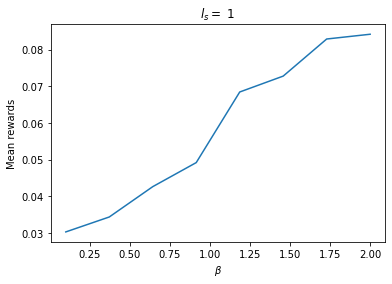

In [9]:
plt.plot(alphas, m_eta)
plt.xlabel(r'$\beta$'); plt.ylabel('Mean rewards')
plt.title(fr'$l_s =$ {ls}')

Text(0.5, 1.0, '$l_s =$ 150')

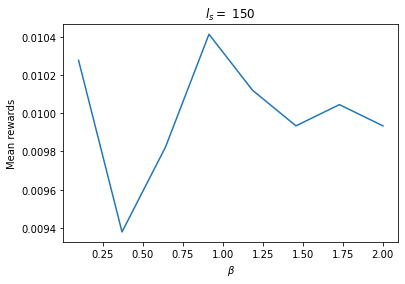

In [148]:
plt.plot(alphas, m_eta)
plt.xlabel(r'$\beta$'); plt.ylabel('Mean rewards')
plt.title(fr'$l_s =$ {ls}')

Text(0.5, 1.0, '$l_s =$ 0.6')

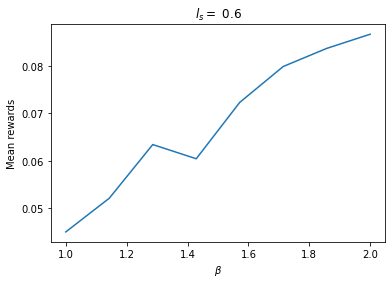

In [130]:
plt.plot(alphas, m_eta)
plt.xlabel(r'$\beta$'); plt.ylabel('Mean rewards')
plt.title(fr'$l_s =$ {ls}')

Text(0.5, 1.0, '$l_s =$ 0.6')

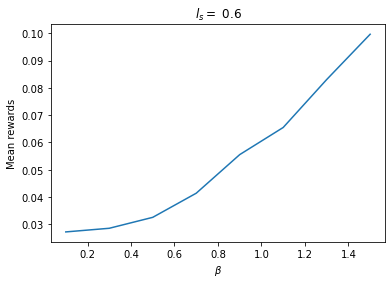

In [114]:
plt.plot(alphas, m_eta)
plt.xlabel(r'$\beta$'); plt.ylabel('Mean rewards')
plt.title(fr'$l_s =$ {ls}')

Text(0.5, 1.0, '$l_s =$ 3')

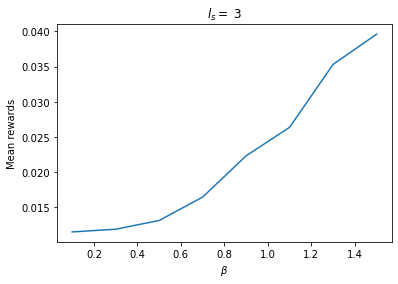

In [108]:
plt.plot(alphas, m_eta)
plt.xlabel(r'$\beta$'); plt.ylabel('Mean rewards')
plt.title(fr'$l_s =$ {ls}')

In [14]:
steps = results[:, 1]    

In [21]:
real_steps = []
for s in steps:
    real_steps += s

In [25]:
h, e = np.histogram(real_steps, bins = 50);

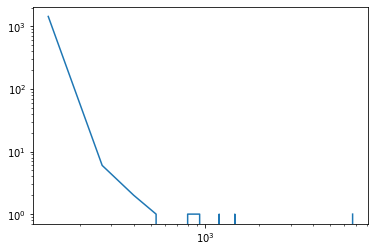

In [26]:
plt.loglog(e[1:], h)

In [56]:
pos = np.random.rand(3,5,6)
pos[(pos < 0.2) | (pos > 0.8)] = -123

## Results

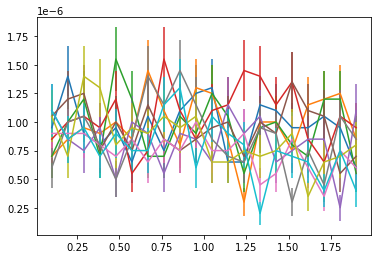

In [31]:
for m, s in zip(m_eta, std_eta):
    plt.errorbar(alphas, m, yerr=s/np.sqrt(N*T))
#     plt.show()

<ErrorbarContainer object of 3 artists>

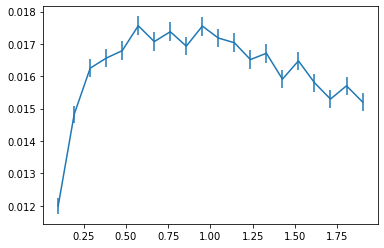

In [24]:
plt.errorbar(alphas, m_eta, yerr=std_eta/np.sqrt(e.shape[0]*e.shape[1]))

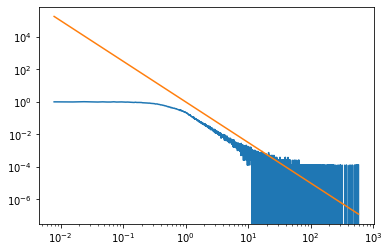

In [25]:
h, e = np.histogram(real_steps, bins = int(len(real_steps)*0.1))
plt.loglog(e[1:], h/h[0])
plt.plot(e[1:], e[1:]**(-alpha-1))

In [28]:
np.ceil(real_steps[:100])

array([1., 1., 1., 1., 1., 1., 4., 2., 3., 1., 5., 7., 1., 1., 1., 1., 2.,
       2., 2., 8., 2., 2., 2., 1., 1., 1., 1., 1., 4., 8., 1., 3., 1., 4.,
       1., 2., 1., 2., 1., 1., 1., 1., 1., 1., 1., 3., 1., 1., 1., 1., 2.,
       1., 1., 1., 4., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 2., 1., 1., 1., 1., 2., 1., 2., 1., 2., 1., 1., 1., 1., 1.,
       1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 1., 1.])

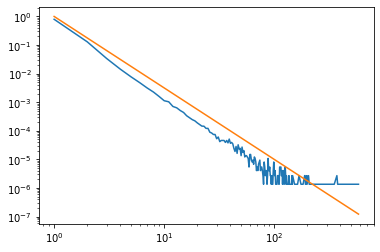

In [34]:
int_steps = np.ceil(real_steps)
h, e = np.unique(int_steps, return_counts=True)
plt.loglog(h, e/np.sum(e))
plt.plot(h, h**(-alpha-1))

In [9]:

70%30

10

In [34]:
len(enc[1])

9498

In [39]:
alpha = 1

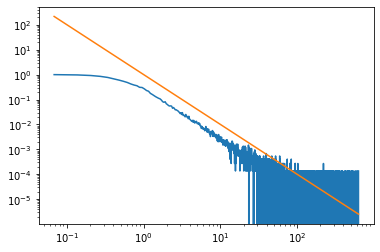

In [44]:
h, e = np.histogram(enc[1], bins = int(len(enc[1])*0.1))
plt.loglog(e[1:], h/h[0])
plt.plot(e[1:], e[1:]**(-alpha-1))

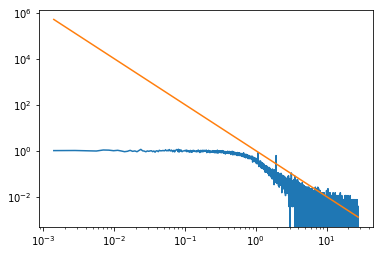

In [12]:
h, e = np.histogram(enc[1], bins = int(len(enc[1])*0.1))
plt.loglog(e[1:], h/h[0])
plt.plot(e[1:], e[1:]**(-alpha-1))

In [18]:
e

array([2.37023094e-06, 1.40173495e-03, 2.80109966e-03, ...,
       2.79802998e+01, 2.79816992e+01, 2.79830986e+01])

In [17]:
h, e = np.histogram(enc[1], bins = int(len(enc[1])*0.1))
e = e[:-1]
h[e == 1] =

143334

In [27]:
Nt = 1000
N = 10000; T = int(1e4)
L = 450 
at = 0.5

alphas = np.linspace(0.2, 2, num = 18)
pos_alpha = np.zeros((len(alphas), N, T, 2))
encounter_alpha = np.zeros((len(alphas), N, T, 2))


info = Parallel(n_jobs=18)(delayed (LW_search) (Nt = Nt, N = N, T = T, alpha = alpha, L = L, at = at)
                                    for alpha in alphas)
    

MemoryError: Unable to allocate 763. MiB for an array with shape (10000, 10000) and data type float64

In [29]:
enc = np.zeros(len(alphas))
mean = np.zeros(len(alphas))
std = np.zeros(len(alphas))



for idx, ia in enumerate(info):
    enc[idx] = np.sum(ia[1])
    totalN = np.sum(ia[1], axis = 1)
    mean[idx] = np.mean(totalN)
    std[idx] = np.std(totalN)

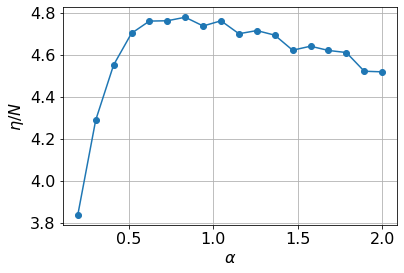

In [57]:
plt.plot(alphas, mean, 'o-')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\eta / N$')
plt.grid('on')

# Multi-exponential 

In [70]:
#| export
def multiexp_dist(x, ws, ds):
    val = 0
    for wi, di in zip(ws, ds):
        # discrete normalization from 1 to inf
        norm = (wi/di)/(np.exp(1/di)-1)
        val += (1/norm)* (wi/di) * np.exp(- x / di) 
    return val/len(ws)

In [81]:
def binomial(x, d_int, d_ext, w):
    return w*(1-np.exp(-1/d_int))*np.exp(-(x-1)/d_int)+(1-w)*(1-np.exp(-1/d_ext))*np.exp(-(x-1)/d_ext)

In [71]:
x = np.arange(1, 3000)

pdf1 = multiexp_dist(x, [0.95, 0.05], [0.05, 1e3])

In [83]:
np.sum(binomial(x, 0.05, 10000, 0.95))

0.9629553846895856

In [94]:
pdf = binomial(x = x, d_int = 0.05, d_ext = d_ext, w = 0.95)
pdf /= np.sum(pdf)
np.random.choice(np.arange(1, 3000), p = pdf)

1

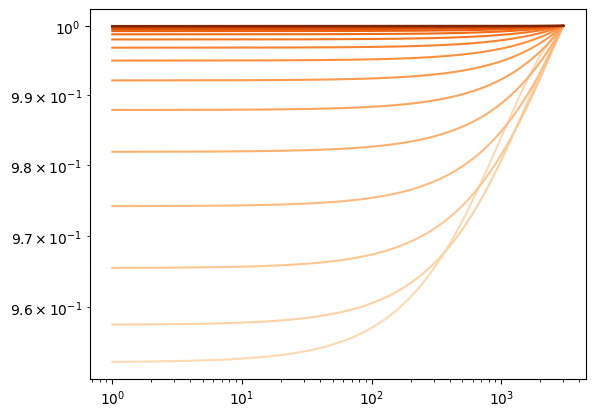

In [113]:
d_exts = np.logspace(3, 7, 20)
cmap = plt.get_cmap('Oranges')
colors = cmap(np.linspace(0.2,1, len(d_exts)))
norm = []
for d_ext, c in zip(d_exts, colors):
    pdf = binomial(x = x, d_int = 0.05, d_ext = d_ext, w = 0.95)
    pdf /= np.sum(pdf)
    
    # sample = np.random.choice(np.arange(1, 3000), size = int(1e4), p = pdf)
        
        
    # plt.loglog(x, pdf, c = c)
    plt.loglog(np.arange(1, len(pdf)+1), np.cumsum(pdf), c=c)
    norm.append(pdf[0])

In [109]:
np.sum(pdf)

0.9999999999999998

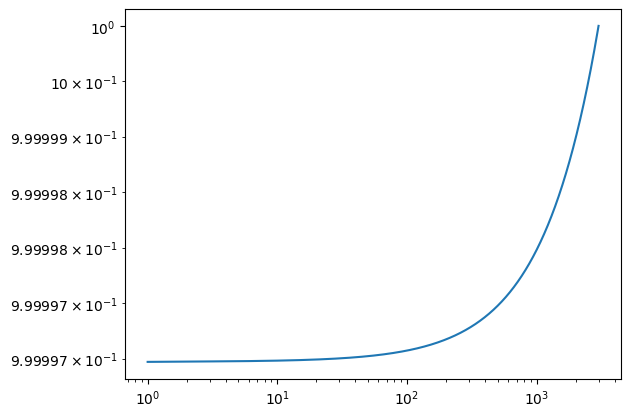

In [111]:
plt.loglog(np.arange(1, len(pdf)+1), np.cumsum(pdf))

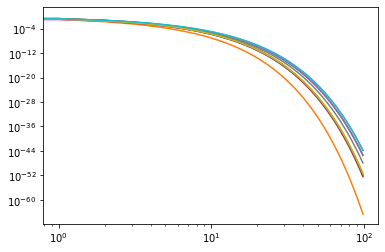

In [23]:
for idx in range(10):
    ws = np.arange(3)
    ws[0] = (10**idx)
    ws = ws/np.sum(ws)
    ds = np.random.rand(3)
    b = multiexp_dist(np.arange(1, 100), ws, ds)

    plt.loglog(b)
# plt.ylim(ymin = 1e-3)

In [41]:
#| export
def discrete_multiexp_step(ws, ds, L_max=1000, num_samples = 1):
    probs = multiexp_dist(np.arange(1, L_max), ws, ds)
    probs /= np.sum(probs)
    return np.random.choice(np.arange(1, L_max), p = probs, size = num_samples)

In [24]:
samples = discrete_multiexp_step(ws, ds, num_samples=int(1e6))

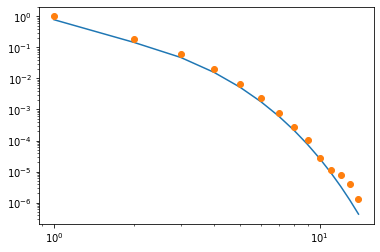

In [25]:
ls = np.arange(1, np.max(samples)+1)
true = multiexp_dist(ls, ws, ds)
u, c = np.unique(samples, return_counts = True)
# true[true < 1e-5] = 1e-5
plt.loglog(ls , true)
plt.loglog(u, c/np.max(c), 'o')

# MFPT 

## 1D 

#### Trajectory generator

In [129]:
#| export
def constant_velocity_generator(N, # Number of trajectories
                                T, # Length of trajectories
                                time_sampler, # Sampler of time of constant velocity
                                velocity = 1, # Velocity
                                **sample_args # Optional arguments for the sampler
                               ):
    ''' Given a sampler for length of time steps, generates a trajectory considering a constant
    velocity in the sampled times. After each time step, we sample a new direction. '''
    
    trajs = np.zeros((N, T))
    
    for idxN in (range(N)):        
        
        times = time_sampler(num_samples = T+1, **sample_args).astype(int)
        
        max_t = np.argwhere(np.cumsum(times) > T+1).flatten()
        if len(max_t) > 0:
            max_t = max_t[0]
        else: max_t = T+1
        
        traj = np.array([0])
        cumsum = 0
        for time in times[:max_t+1]:
            segment = (2*np.random.randint(0, 2)-1)*np.arange(1, min(time+1, T+1))+traj[-1]
            
            traj = np.append(traj, segment)
            cumsum += len(segment)
            if cumsum > T:
                break

        trajs[idxN] = traj[:T]
        
    return trajs
    

In [42]:
N = 5; T = 150
trajs_lw = constant_velocity_generator(N, T, time_sampler = lw_step, beta = 1)

def single_steps(num_samples):
    return np.ones(num_samples)

trajs_rw = constant_velocity_generator(N, T, time_sampler = single_steps, velocity = 1.2)


100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 454.57it/s]


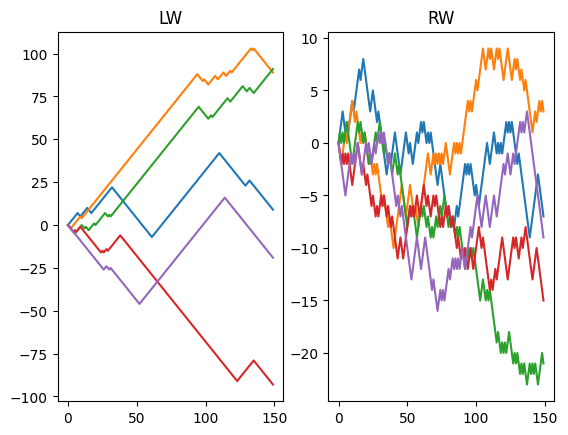

In [43]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(trajs_lw.transpose())
ax[0].set_title('LW')
ax[1].plot(trajs_rw.transpose())
ax[1].set_title('RW');

#### MFPT calculator

Uniformed

In [130]:
#| export
from typing import Callable

def mfpt_rw(N:int, # Number of trajectories
            T:int, # Lengths of trajectories
            x0:float, # Starting point of walk
            Ls:list, # Boundary position
            traj_generator:Callable,  # Function generating the walk (must start in x0 = zero)
            max_loop = 5,  # Max number of while loop if some walks do not reach the boundary
            save = None,
            **args_generator # Arguments of the trajectory generator
           ): # MFPT vs. L
    ''' Calculates MFPT to boundaries at 0 and L starting in x0 '''
    
    trajs = traj_generator(N,T,**args_generator) + x0
    
    if save is not None:
        statistics_fpt = np.zeros((len(Ls), N))

    mfpt = []
    for idxL, L in tqdm_term(enumerate(Ls)):   
        first_passage = np.argmax((trajs < 0) | (trajs > L), axis = 1) 

        # Enlarging the time of those who did not hit the boundaries
        n_loop = 0
        non_passed = np.argwhere(first_passage == 0).flatten()
        last_non_passed = trajs[non_passed, -1]
        while len(non_passed) > 0 and n_loop < max_loop:
            
            trajs_upd = traj_generator(len(non_passed),T,**args_generator) + last_non_passed[..., np.newaxis]
            
            # Finding the FPT of the new trajectories
            first_upd = np.argmax((trajs_upd < 0) | (trajs_upd > L), axis = 1)            
            # Adding these to the main FPT array, considering that loop number
            first_passage[non_passed] = (first_upd + (n_loop+1)*T)*first_upd.astype(bool)

            # Checking the ones that still did not pass
            non_passed = np.argwhere(first_passage == 0).flatten()
            # updating the last element of the non passed trajectories
            upd_non_passed = np.argwhere(first_upd == 0).flatten()
            if len(non_passed) != len(upd_non_passed): print('ERROR')
            last_non_passed = trajs_upd[upd_non_passed, -1]
            # updating loop num
            n_loop += 1      
                                  
        if save is not None:
            statistics_fpt[idxL] = first_passage.copy()
                                

        # Calculating mean considering that some may not have passed              
        first_passage = first_passage[first_passage != 0].mean() 
        # Adding this MFPT for current L
        mfpt.append(first_passage)
        
        
        
    if save is not None:
        np.save(save+'.npy', mfpt)
        np.save(save+'_stats.npy', statistics_fpt)
        
    return mfpt

Informed

In [132]:
#| export
def mfpt_informed_rw(N:int, # Number of trajectories
            T:int, # Lengths of trajectories
            x0:float, # Starting point of walk
            Ls:list, # Boundary position
            traj_generator:Callable,  # Function generating the walk (must start in x0 = zero)
            max_loop = 5,  # Max number of while loop if some walks do not reach the boundary
            time_sampler = None,
            save = None,
            **args_generator # Optional                     
           ): # MFPT vs. L
    ''' Calculates MFPT to boundaries at 0 and L starting in x0 with a traj generator informed on the scales of the sysmte (x0 and L)'''
    
    if save is not None:
        statistics_fpt = np.zeros((len(Ls), N))

    mfpt = []
    for idxL, L in tqdm_term(enumerate(Ls)):  
        
        trajs = traj_generator(N, T, time_sampler = time_sampler, x0 = x0, L = L, informed = True)
        
        first_passage = np.argmax((trajs < 0) | (trajs > L), axis = 1) 

        # Enlarging the time of those who did not hit the boundaries
        n_loop = 0
        non_passed = np.argwhere(first_passage == 0).flatten()
        while len(non_passed) > 0 and n_loop < max_loop:
            last_non_passed = trajs[non_passed, -1]
            trajs_upd = traj_generator(len(non_passed),T, 
                                       time_sampler = time_sampler, x0 = x0, L = L, 
                                       informed = True) + last_non_passed[..., np.newaxis]

            # updating trajectories with new positions. This makes that last_non_passed is always correct
            trajs[non_passed, -1] = trajs_upd[:, -1]
            # Finding the FPT of the new trajectories
            first_upd = np.argmax((trajs_upd < 0) | (trajs_upd > L), axis = 1)            
            # Adding these to the main FPT array, considering that loop number
            first_passage[non_passed] = (first_upd + (n_loop+1)*T)*first_upd.astype(bool)

            # Checking the ones that still did not pass
            non_passed = np.argwhere(first_passage == 0).flatten()
            # updating loop num
            n_loop += 1      
                                  
        if save is not None:
            statistics_fpt[idxL] = first_passage.copy()
                                

        # Calculating mean considering that some may not have passed              
        first_passage = first_passage[first_passage != 0].mean() 
        # Adding this MFPT for current L
        mfpt.append(first_passage)
        
        
        
    if save is not None:
        np.save(save+'.npy', mfpt)
        np.save(save+'_stats.npy', statistics_fpt)
        
    return mfpt

### Discrete walking
In this case we are already doing constant velocities, hence we can use the generator below:

In [8]:
#| export
def rw_generator(N, T):
    trajs = 2*np.random.randint(0, 2, size = (N,T))-1
    trajs[:,0] = 0
    trajs = np.cumsum(trajs, axis = 1)
    return trajs

In [46]:
N = int(1e2)
T = int(1e6)
x0 = 3
Ls = np.arange(15, 100)

reps = 20
results = np.array(Parallel(n_jobs=20)(delayed(mfpt_rw)(N = N, T = T, x0 = x0, Ls = Ls, 
                                                        traj_generator = rw_generator)
                for _ in tqdm(range(reps))), dtype = object)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 85/85 [00:52<00:00,  1.63it/s]


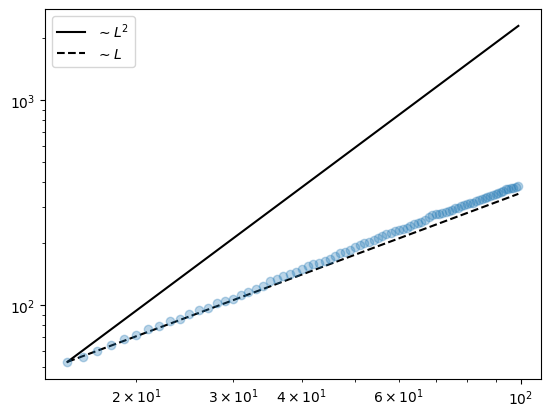

In [47]:
mean = results.mean(0)

plt.plot(Ls, mean[0]*(Ls/Ls[0])**2,c = 'k', label = r'$\sim L^2$')
plt.plot(Ls, mean[0]*(Ls/Ls[0]), c = 'k',ls = '--', label = r'$\sim L$')
plt.loglog(Ls, mean,'o', alpha = 0.3)
plt.legend()

# plt.xlim(xmax = 150)

### Exponential

In [171]:
#| export
def exp_generator(N, T):
    trajs = (2*np.random.randint(0, 2, size = (N,T))-1)*np.random.exponential(size = (N,T))
    trajs[:,0] = 0
    trajs = trajs.cumsum(axis = 1)
    return trajs

In [10]:
#| export
def exp_time_generator(num_samples):
    return np.random.exponential(size = num_samples)+1

In [59]:
N = int(1e2)
T = int(1e4)
x0 = 3
Ls = np.arange(15, 100)

reps = 20
results = np.array(Parallel(n_jobs=20)(delayed(mfpt_rw)(N = N, T = T, x0 = x0, Ls = Ls,
                                                        traj_generator = constant_velocity_generator,
                                                        time_sampler = exp_time_generator)
                for _ in tqdm(range(reps))), dtype = object)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 85/85 [00:00<00:00, 1748.04it/s]


(23.655963721815578, 500)

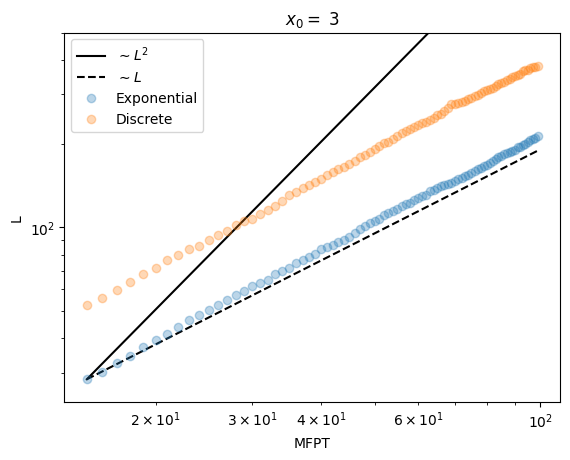

In [60]:
mean_exp = results.mean(0)

plt.plot(Ls, mean_exp[0]*(Ls/Ls[0])**2,c = 'k', label = r'$\sim L^2$')
plt.plot(Ls, mean_exp[0]*(Ls/Ls[0]), c = 'k',ls = '--', label = r'$\sim L$')
plt.loglog(Ls, mean_exp,'o', alpha = 0.3, label = 'Exponential')
plt.loglog(Ls, mean,'o', alpha = 0.3, label = 'Discrete')
plt.legend()
plt.xlabel('MFPT'); plt.ylabel('L'); plt.title(fr'$x_0 =$ {x0}') 
plt.ylim(ymax = 500)

### Biexponential

##### Sampler

In [11]:
#| export
from scipy.stats.sampling import NumericalInverseHermite

class Biexp():
    def __init__(self, informed = False, **args):
        
        if not informed:
            self.w1 = args['w1']
            self.d1 = args['d1']
            self.d2 = args['d2']
        else:
            self.w1 = 2*args['x0']/args['L']
            self.d1 = 3*args['L']
            self.d2 = args['x0']        
            
        
    def pdf(self, x):
        return (self.w1/self.d1)*np.exp(-x/self.d1) + ((1 - self.w1)/ self.d2)*np.exp(-x/self.d2)
    
    def cdf(self, x):
        return 1 + (self.w1-1)*np.exp(-x/self.d2) - self.w1*np.exp(-x/self.d1)
    
    def dpdf(self, x):
        return (self.w1/self.d1**2)*np.exp(-x/self.d1) + ((1 - self.w1)/ self.d2**2)*np.exp(-x/self.d2)
    
    def sample(self, num_rn):
        return NumericalInverseHermite(self, domain=(0, np.inf)).rvs(int(num_rn))

In [133]:
bi = Biexp(0.1, 1, 200)
bi_rng = bi.sample(int(1e6))

In [134]:
h, e = np.histogram(bi_rng, bins = np.linspace(0.1,100, 2000), density=True)

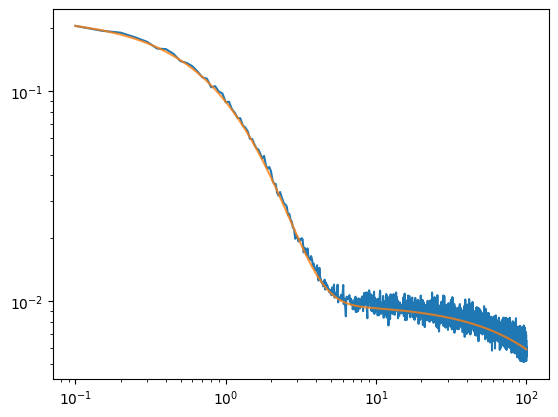

In [135]:
plt.loglog(e[:-1], h)
plt.plot(e, bi.pdf(e)*(h[0]/bi.pdf(e[0])), alpha = 0.8)

In [216]:
def biexp_generator(N, T, sampler = Biexp, **sample_kwargs):
    direction =  (2*np.random.randint(0, 2, size = (N,T))-1)
    sampler = sampler(**sample_kwargs)
    step = sampler.sample(int(N*T)).reshape(N,T)
    trajs = direction*step
    trajs[:,0] = 0
    trajs = trajs.cumsum(axis = 1)
    return trajs

In [13]:
#| export
def biexp_time_generator(num_samples, **sample_kwargs):
    sampler = Biexp(**sample_kwargs)
    return sampler.sample(num_samples)+1

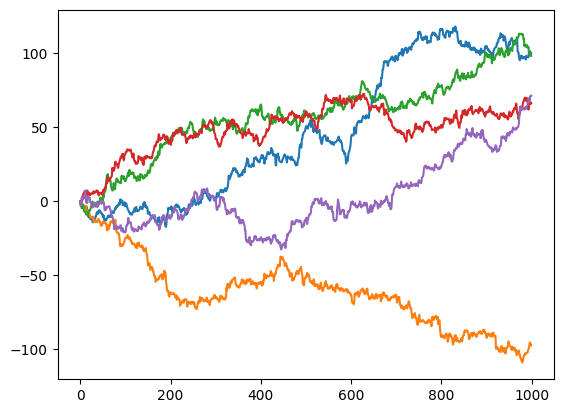

In [154]:
plt.plot(biexp_generator(5, 1000, w1 = 0, d1 = 10, d2 = 1).transpose())

#### Uninformed

In [65]:
N = int(1e2)
T = int(1e4)
x0 = 3
Ls = np.arange(15, 100)

reps = 20
results = np.array(Parallel(n_jobs=20)(delayed(mfpt_rw)(N = N, T = T, x0 = x0, Ls = Ls,
                                                        traj_generator = constant_velocity_generator,
                                                        time_sampler = biexp_time_generator, w1 = 0.5, d1 = 1, d2 = 5)
                for _ in tqdm(range(reps))), dtype = object)

mean_uninf_biexp = results.mean(0)


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 85/85 [00:00<00:00, 1018.79it/s]


Text(0.5, 1.0, '$x_0 =$ 3')

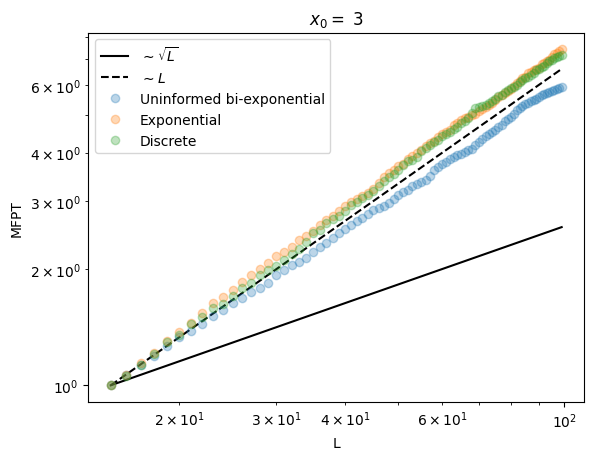

In [67]:

plt.plot(Ls, (Ls/Ls[0])**(1/2),c = 'k', label = r'$\sim \sqrt{L}$')
plt.plot(Ls, (Ls/Ls[0]), c = 'k',ls = '--', label = r'$\sim L$')

plt.loglog(Ls, mean_uninf_biexp/mean_uninf_biexp[0],'o', alpha = 0.3, label = 'Uninformed bi-exponential')
plt.loglog(Ls, mean_exp/mean_exp[0],'o', alpha = 0.3, label = 'Exponential')
plt.loglog(Ls, mean/mean[0],'o', alpha = 0.3, label = 'Discrete')
plt.legend()
plt.ylabel('MFPT'); plt.xlabel('L'); plt.title(fr'$x_0 =$ {x0}') 

#### Informed

In [22]:
N = int(1e2)
T = int(1e4)
x0 = 3
Ls = np.arange(15, 100)

reps = 20
results = np.array(Parallel(n_jobs=10)(delayed(mfpt_informed_rw)(N = N, T = T, x0 = x0, Ls = Ls, 
                                                                 traj_generator = constant_velocity_generator,
                                                                 time_sampler = biexp_time_generator)
                for _ in tqdm(range(reps))), dtype = object)

mean_biexp = results.mean(0)

  0%|          | 0/200 [00:00<?, ?it/s]


KeyboardInterrupt



Text(0.5, 1.0, '$x_0 =$ 3')

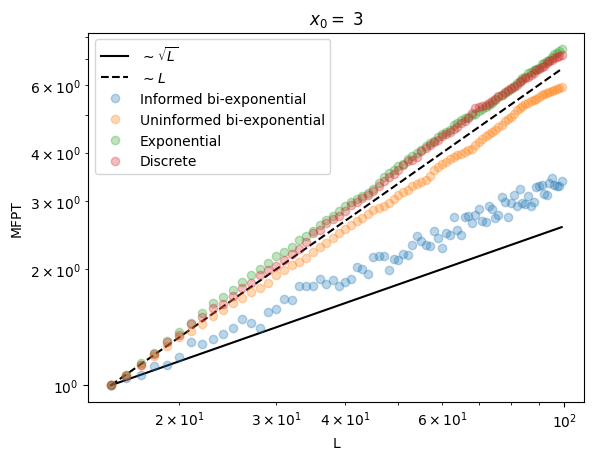

In [77]:
plt.plot(Ls, (Ls/Ls[0])**(1/2),c = 'k', label = r'$\sim \sqrt{L}$')
plt.plot(Ls, (Ls/Ls[0]), c = 'k',ls = '--', label = r'$\sim L$')


plt.loglog(Ls, mean_biexp/mean_biexp[0],'o', alpha = 0.3, label = 'Informed bi-exponential')
plt.loglog(Ls, mean_uninf_biexp/mean_uninf_biexp[0],'o', alpha = 0.3, label = 'Uninformed bi-exponential')
plt.loglog(Ls, mean_exp/mean_exp[0],'o', alpha = 0.3, label = 'Exponential')
plt.loglog(Ls, mean/mean[0],'o', alpha = 0.3, label = 'Discrete')
plt.legend()
plt.ylabel('MFPT'); plt.xlabel('L'); plt.title(fr'$x_0 =$ {x0}') 

### Power-law

In [396]:
#| export
def powerlaw_generator(N, T, **args):    
    direction =  (2*np.random.randint(0, 2, size = (N,T))-1)    
    steps = lw_step(num_part=int(N*T), **args).reshape(N,T)
    trajs = direction*steps
    trajs[:,0] = 0
    trajs = trajs.cumsum(axis = 1)
    # Regularize trajectories
    for idxt, (traj, step) in enumerate(zip(trajs, steps)):
        times = np.cumsum(step)
        trajs[idxt] = regularize(traj, times, T)
    return trajs

In [84]:
N = int(1e2)
T = int(1e5)
x0 = 3
Ls = np.arange(15, 100)

beta = 1

# mean_pw_long = mfpt_rw(N = N, T = T, x0 = x0, Ls = Ls, traj_generator = powerlaw_generator, beta = 0.21)

# results = np.array(Parallel(n_jobs=len(betas))(delayed(mfpt_rw)(N = N, T = T, x0 = x0, Ls = Ls, 
#                                                                  traj_generator = constant_velocity_generator,
#                                                                  time_sampler = lw_step, beta = beta)
#                 for beta in tqdm(betas)), dtype = object)

results = np.array(Parallel(n_jobs=10)(delayed(mfpt_rw)(N = N, T = T, x0 = x0, Ls = Ls, 
                                                        traj_generator = constant_velocity_generator,
                                                        time_sampler = lw_step, beta = beta)
                for _ in tqdm(range(reps))), dtype = object)

mean_pw = results.mean(0)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 85/85 [00:00<00:00, 114.97it/s]


#### Check multiple $\beta$

In [23]:
N = int(1e3)
T = int(1e5)
x0 = 3
Ls = np.arange(15, 100)

betas = np.linspace(0.1, 1.5, 10)

# mean_pw_long = mfpt_rw(N = N, T = T, x0 = x0, Ls = Ls, traj_generator = powerlaw_generator, beta = 0.21)

results = np.array(Parallel(n_jobs=len(betas))(delayed(mfpt_rw)(N = N, T = T, x0 = x0, Ls = Ls, 
                                                                 traj_generator = constant_velocity_generator,
                                                                 time_sampler = lw_step, beta = beta)
                for beta in tqdm(betas)), dtype = object)


mean_pw_betas = results.mean(0)

  0%|          | 0/10 [00:00<?, ?it/s]

Finished generating trajectories
Finished generating trajectories


  0%|          | 0/85 [00:00<?, ?it/s].73it/s]]

Finished generating trajectories


 53%|█████▎    | 45/85 [00:05<00:05,  7.79it/s]

Finished generating trajectories


100%|██████████| 85/85 [00:09<00:00,  8.97it/s]


Finished generating trajectories


100%|██████████| 85/85 [00:07<00:00, 11.68it/s]


Finished generating trajectories


100%|██████████| 85/85 [00:07<00:00, 11.33it/s]


Finished generating trajectories


100%|██████████| 85/85 [00:07<00:00, 11.99it/s]


Finished generating trajectories


100%|██████████| 85/85 [00:07<00:00, 11.79it/s]


Finished generating trajectories


100%|██████████| 85/85 [00:07<00:00, 11.70it/s]


Finished generating trajectories


100%|██████████| 85/85 [00:07<00:00, 11.66it/s]


[Text(0, 0.5, 'MFPT'), Text(0.5, 0, 'L'), Text(0.5, 1.0, '$x_0 =$ 3')]

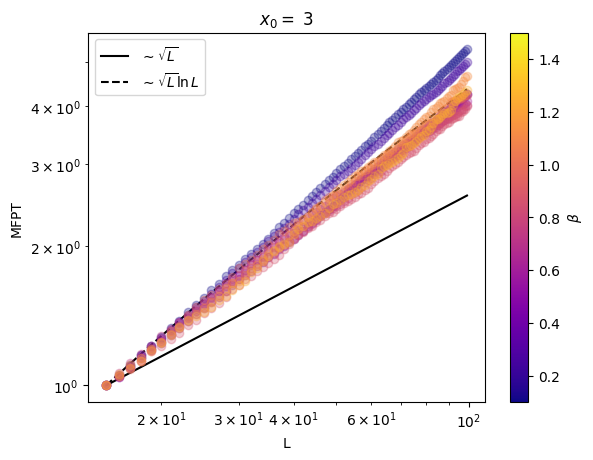

In [24]:
from rl_optimal_search.utils import add_colorbar

fig, ax = plt.subplots()
ax.plot(Ls, (Ls/Ls[0])**(1/2),c = 'k', label = r'$\sim \sqrt{L}$')
pw_scaling = np.log(Ls)*(Ls**(1/2))
ax.plot(Ls, pw_scaling/pw_scaling[0], c = 'k',ls = '--', label = r'$\sim \sqrt{L}\ln{L}$')


colors = plt.cm.plasma(np.linspace(0,1,len(betas)+2))
for res, c in zip(results, colors):
    ax.loglog(Ls, res/res[0], 'o', c = c, alpha = 0.3)

add_colorbar(betas, ax, fig, r'$\beta$')
ax.legend()
plt.setp(ax, ylabel = 'MFPT', xlabel = 'L', title = fr'$x_0 =$ {x0}') 

Text(0.5, 1.0, '$x_0 =$ 3')

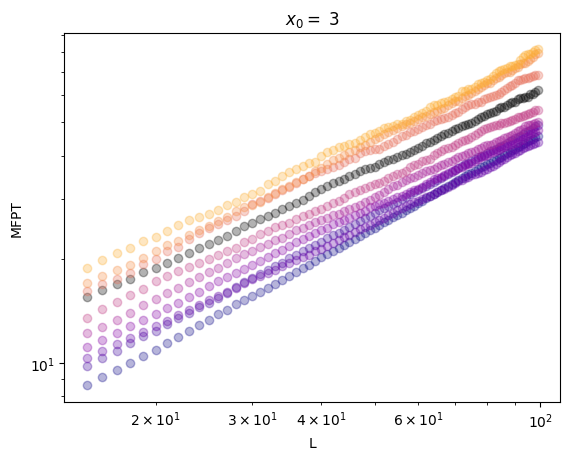

In [30]:
colors = plt.cm.plasma(np.linspace(0,1,len(betas)+2))
for res, c, beta in zip(results, colors, betas):
    if round(beta, 1) == 1: c = 'k'
    plt.loglog(Ls, res, 'o', c = c, alpha = 0.3)
plt.ylabel('MFPT'); plt.xlabel('L'); plt.title(fr'$x_0 =$ {x0}') 

Smaller $\beta$

[Text(0, 0.5, 'MFPT'), Text(0.5, 0, 'L'), Text(0.5, 1.0, '$x_0 =$ 0.02')]

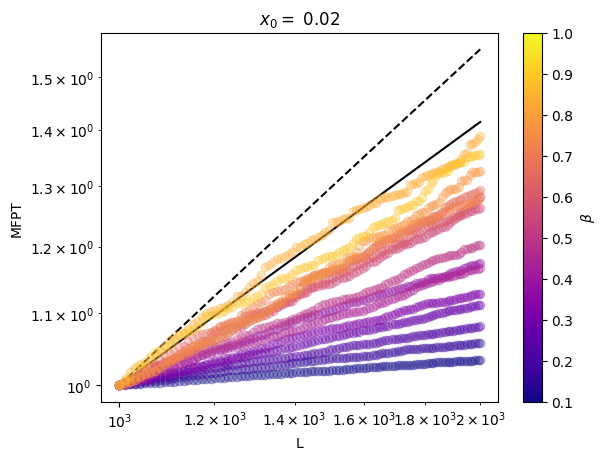

In [380]:
fig, ax = plt.subplots()
ax.plot(Ls, (Ls/Ls[0])**(1/2),c = 'k', label = r'$\sim \sqrt{L}$')
pw_scaling = np.log(Ls)*(Ls**(1/2))
ax.plot(Ls, pw_scaling/pw_scaling[0], c = 'k',ls = '--', label = r'$\sim \sqrt{L}\ln{L}$')


colors = plt.cm.plasma(np.linspace(0,1,len(betas)+2))
for res, c in zip(results, colors):
    ax.loglog(Ls, res/res[0], 'o', c = c, alpha = 0.3)

add_colorbar(betas, ax, r'$\beta$')
plt.setp(ax, ylabel = 'MFPT', xlabel = 'L', title = fr'$x_0 =$ {x0}') 

Text(0.5, 1.0, '$x_0 =$ 0.02')

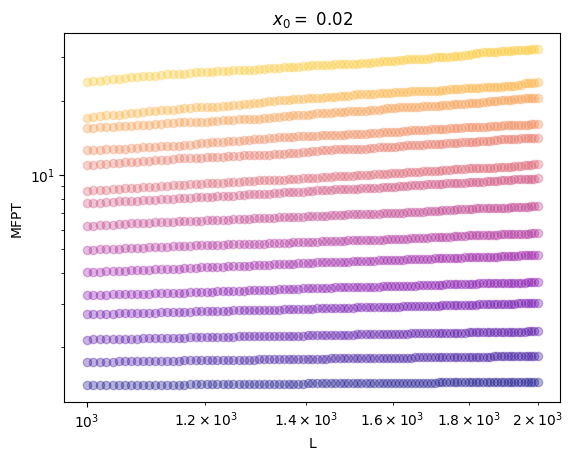

  0%|          | 0/100 [00:00<?, ?it/s]


In [378]:
colors = plt.cm.plasma(np.linspace(0,1,len(betas)+2))
for res, c in zip(results, colors):
    plt.loglog(Ls, res, 'o', c = c, alpha = 0.3)
plt.ylabel('MFPT'); plt.xlabel('L'); plt.title(fr'$x_0 =$ {x0}') 

### Full comparison


Saving the data for future tests

In [271]:
datas = [mean, mean_exp, mean_biexp, mean_uninf_biexp, mean_pw]
names = ['discrete', 'exp', 'inf_biexp', 'uninf_biexp', 'pw']
for data, name in zip(datas, names):
    np.save('scalings_mfpt/'+name+f'_N_{N}_T_{T}_x0_{x0}_L_{min(Ls)}-{max(Ls)}.npy', data)

[Text(0, 0.5, 'MFPT'),
 Text(0.5, 0, 'L'),
 Text(0.5, 1.0, '$x_0 =$ 3'),
 Text(0, 0.5, 'MFPT'),
 Text(0.5, 0, 'L'),
 Text(0.5, 1.0, '$x_0 =$ 3')]

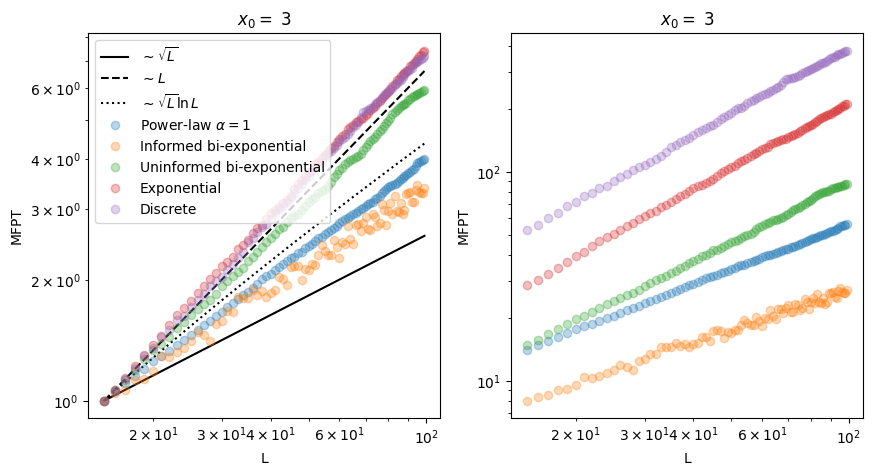

In [86]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

ax[0].plot(Ls, (Ls/Ls[0])**(1/2),c = 'k', label = r'$\sim \sqrt{L}$')
ax[0].plot(Ls, (Ls/Ls[0]), c = 'k',ls = '--', label = r'$\sim L$')
pw_scaling = np.log(Ls)*Ls**(1/2)
ax[0].plot(Ls, pw_scaling/pw_scaling[0], c = 'k',ls = ':', label = r'$\sim \sqrt{L}\ln{L}$')

ax[0].loglog(Ls, mean_pw/mean_pw[0],' o', alpha = 0.3, label = r'Power-law $\alpha = 1$')
ax[0].loglog(Ls, mean_biexp/mean_biexp[0],'o', alpha = 0.3, label = 'Informed bi-exponential')
ax[0].loglog(Ls, mean_uninf_biexp/mean_uninf_biexp[0],'o', alpha = 0.3, label = 'Uninformed bi-exponential')
ax[0].loglog(Ls, mean_exp/mean_exp[0],'o', alpha = 0.3, label = 'Exponential')
ax[0].loglog(Ls, mean/mean[0],'o', alpha = 0.3, label = 'Discrete')
ax[0].legend()


ax[1].loglog(Ls, mean_pw,' o', alpha = 0.3, label = r'Power-law $\alpha = 1$')
ax[1].loglog(Ls, mean_biexp,'o', alpha = 0.3, label = 'Informed bi-exponential')
ax[1].loglog(Ls, mean_uninf_biexp,'o', alpha = 0.3, label = 'Uninformed bi-exponential')
ax[1].loglog(Ls, mean_exp,'o', alpha = 0.3, label = 'Exponential')
ax[1].loglog(Ls, mean,'o', alpha = 0.3, label = 'Discrete')



plt.setp(ax, ylabel = 'MFPT', xlabel = 'L', title = fr'$x_0 =$ {x0}') 
                    

### Cluster launch

In [193]:
#| export
x0, Ls = 3, np.arange(15, 100)
n_jobs = 10
reps = 5000

betas = np.linspace(0.1, 1.5, 10)

names = ['constant', 'exp', 'biexp_unif', 'biexp_inf', 'pw']
Ts = (np.array([1e4, 1e4, 1e4, 1e4, 1e3], dtype = int)).astype(int)
Ns = (np.array([1e3, 1e3, 1e3, 1e2, 1e4], dtype = int)).astype(int)
path = 'results_fpt/'



for idx in [3]:#range(len(names)):
    
    print(names[idx])
    
    if idx == 0: # Constant step length
        Parallel(n_jobs=n_jobs)(delayed(mfpt_rw)(N = Ns[idx], T = Ts[idx], 
                                                 x0 = x0, Ls = Ls, 
                                                 traj_generator = rw_generator,
                                                 save = path+names[idx]+f'_N_{np.log10(Ns[idx]).astype(int)}_L_{np.log10(Ts[idx]).astype(int)}_{rep}')
                                for rep in tqdm(range(reps)))



    if idx == 1: # Single exponential
        Parallel(n_jobs=n_jobs)(delayed(mfpt_rw)(N = Ns[idx], T = Ts[idx],
                                                 x0 = x0, Ls = Ls,
                                                 traj_generator = constant_velocity_generator,
                                                 time_sampler = exp_time_generator,
                                                 save = path+names[idx]+f'_N_{np.log10(Ns[idx]).astype(int)}_L_{np.log10(Ts[idx]).astype(int)}_{rep}')
                                for rep in tqdm(range(reps)))

    if idx == 2: # Uninformed biexponential
        Parallel(n_jobs=n_jobs)(delayed(mfpt_rw)(N = Ns[idx], T = Ts[idx],
                                                 x0 = x0, Ls = Ls,
                                                 traj_generator = constant_velocity_generator,
                                                 time_sampler = biexp_time_generator, w1 = 0.5, d1 = 1, d2 = 5,
                                                 save = path+names[idx]+f'_N_{np.log10(Ns[idx]).astype(int)}_L_{np.log10(Ts[idx]).astype(int)}_{rep}')
                                for rep in tqdm(range(reps)))


    
    if idx == 3: # Informed biexponential
        Parallel(n_jobs=n_jobs)(delayed(mfpt_informed_rw)(N = Ns[idx], T = Ts[idx],
                                                          x0 = x0, Ls = Ls, 
                                                          traj_generator = constant_velocity_generator,
                                                          time_sampler = biexp_time_generator,
                                                          save = path+names[idx]+f'_N_{np.log10(Ns[idx]).astype(int)}_L_{np.log10(Ts[idx]).astype(int)}_{rep+500}')
                                for rep in tqdm(range(reps)))

    if idx == 4: # Power law multiple betas
        for idxb, beta in enumerate(betas):
            print(round(idxb/len(betas),2))
            Parallel(n_jobs=n_jobs)(delayed(mfpt_rw)(N = Ns[idx], T = Ts[idx],
                                                     x0 = x0, Ls = Ls, 
                                                     traj_generator = constant_velocity_generator,
                                                     time_sampler = lw_step, beta = beta,
                                                     save = path+names[idx]+f'_beta{round(beta,3)}_N_{np.log10(Ns[idx]).astype(int)}_L_{np.log10(Ts[idx]).astype(int)}_{rep}')
                                    for rep in tqdm(range(reps)))

biexp_inf


  0%|          | 0/5000 [00:00<?, ?it/s]

85it [03:23,  2.39s/it]
85it [03:26,  2.43s/it]
85it [03:26,  2.43s/it]
85it [03:27,  2.44s/it]
85it [03:27,  2.44s/it]
85it [03:27,  2.45s/it]
85it [03:27,  2.45s/it]
85it [03:28,  2.45s/it]
85it [03:29,  2.46s/it]
85it [03:29,  2.47s/it]
85it [03:23,  2.39s/it]
85it [03:26,  2.42s/it]
85it [03:26,  2.43s/it]
85it [03:27,  2.44s/it]
85it [03:27,  2.44s/it]
85it [03:27,  2.44s/it]
85it [03:28,  2.45s/it]
85it [03:27,  2.44s/it]
85it [03:29,  2.46s/it]
85it [03:29,  2.47s/it]
85it [03:23,  2.40s/it]
85it [03:26,  2.43s/it]
85it [03:26,  2.43s/it]
85it [03:27,  2.44s/it]
85it [03:27,  2.44s/it]
85it [03:27,  2.44s/it]
85it [03:28,  2.45s/it]
85it [03:28,  2.45s/it]
85it [03:29,  2.46s/it]
85it [03:30,  2.47s/it]
85it [03:23,  2.39s/it]
85it [03:26,  2.43s/it]
85it [03:27,  2.44s/it]
85it [03:27,  2.44s/it]
85it [03:27,  2.44s/it]
85it [03:27,  2.44s/it]
85it [03:28,  2.45s/it]
85it [03:28,  2.45s/it]
85it [03:29,  2.47s/it]
85it [03:29,  2.46s/it]
85it [03:24,  2.40s/it]
85it [03:27,  2.

Reading results

In [194]:
mean_fpt = []
names_read = names#[:3]+[names[-1]]*len(betas)
idxbeta = 6
for idx, name in enumerate(names_read):
    try: del collect_mean
    except: pass    

    if name == 'biexp_inf': reps = 5500
    else: reps = 500
    
    for rep in range(reps):
        if name == 'pw':
            current_m = np.load(path+name+f'_beta{round(betas[idxbeta],3)}_N_{np.log10(Ns[-1]).astype(int)}_L_{np.log10(Ts[-1]).astype(int)}_{rep}.npy')
                
        else:
            current_m = np.load(path+name+f'_N_{np.log10(Ns[idx]).astype(int)}_L_{np.log10(Ts[idx]).astype(int)}_{rep}.npy')
            
        # current_s = np.load(path+name+f'_N_{np.log10(Ns[idx]).astype(int)}_L_{np.log10(Ts[idx]).astype(int)}_{rep}_stats.npy')
        try:
            collect_mean = np.vstack((collect_mean, current_m))
            # collect_stat = np.vstack((collect_stat, current_s))
        except:
            collect_mean = current_m
            # collect_stat = current_s
    mean_fpt.append(collect_mean)

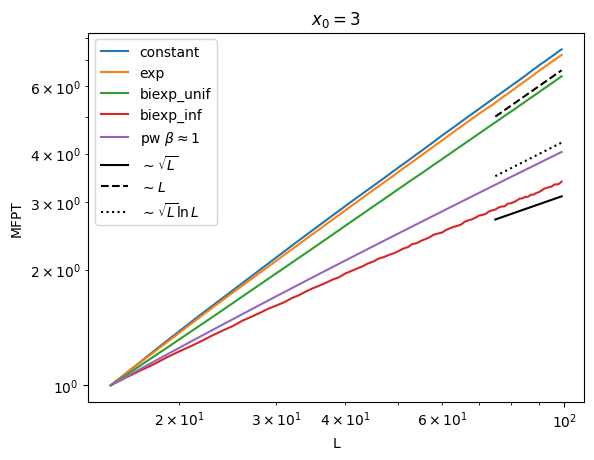

In [195]:
fig, ax = plt.subplots()
minL = 60
Lsplot = Ls[minL:]
for m, n  in zip(mean_fpt, names_read):
    if n == 'pw': n = r'pw $\beta \approx 1$'
    mean = m.mean(0)#[minL:]
    ax.plot(Ls, mean/mean[0], label = n)


ax.plot(Lsplot, 2.7*(Lsplot/Lsplot[0])**(1/2),c = 'k', label = r'$\sim \sqrt{L}$')
ax.plot(Lsplot, 5*(Lsplot/Lsplot[0]), c = 'k',ls = '--', label = r'$\sim L$')
pw_scaling = np.log(Lsplot)*Lsplot**(1/2)
ax.plot(Lsplot, 3.5*pw_scaling/pw_scaling[0], c = 'k',ls = ':', label = r'$\sim \sqrt{L}\ln{L}$')

plt.setp(ax, xscale = 'log', yscale = 'log', xlabel = 'L', ylabel = 'MFPT', title = fr'$x_0 = {x0}$')
ax.legend()

In [164]:
mean_fpt_pw = []
name = 'pw'#[:3]+[names[-1]]*len(betas)

for idxbeta, beta in enumerate(betas):
    try: del collect_mean
    except: pass    

        
    for rep in range(reps):
        current_m = np.load(path+name+f'_beta{round(betas[idxbeta],3)}_N_{np.log10(Ns[-1]).astype(int)}_L_{np.log10(Ts[-1]).astype(int)}_{rep}.npy')
       
        try:
            collect_mean = np.vstack((collect_mean, current_m))
            # collect_stat = np.vstack((collect_stat, current_s))
        except:
            collect_mean = current_m
            # collect_stat = current_s
    mean_fpt_pw.append(collect_mean)

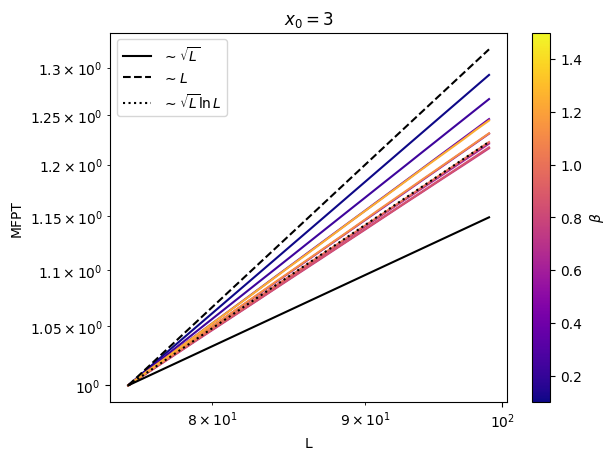

In [170]:
fig, ax = plt.subplots()
minL = 60
Lsplot = Ls[minL:]
colors = plt.cm.plasma(np.linspace(0,1,len(betas)+2))
for m, c  in zip(mean_fpt_pw, colors):
    mean = m.mean(0)[minL:]
    ax.plot(Lsplot, mean/mean[0], c = c)


ax.plot(Lsplot, (Lsplot/Lsplot[0])**(1/2),c = 'k', label = r'$\sim \sqrt{L}$')
ax.plot(Lsplot, (Lsplot/Lsplot[0]), c = 'k',ls = '--', label = r'$\sim L$')
pw_scaling = np.log(Lsplot)*Lsplot**(1/2)
ax.plot(Lsplot, pw_scaling/pw_scaling[0], c = 'k',ls = ':', label = r'$\sim \sqrt{L}\ln{L}$')

plt.setp(ax, xscale = 'log', yscale = 'log', xlabel = 'L', ylabel = 'MFPT', title = fr'$x_0 = {x0}$')
ax.legend()
add_colorbar(betas, ax,fig, r'$\beta$')

In [175]:
fit = []
for m, c  in zip(mean_fpt_pw, colors):
    mean = m.mean(0)[minL:]
    fit.append(np.polyfit(np.log(Lsplot), np.log(mean/mean[0]), deg=1)[0])

[Text(0.5, 0, '$\\beta$'), Text(0, 0.5, 'Fit long time MFPT')]

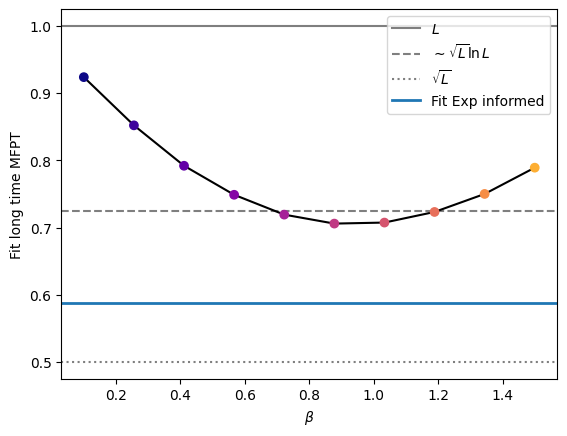

In [207]:
# Approx fit log(L)
app_log =  np.polyfit(np.log(Lsplot), np.log(pw_scaling/pw_scaling[0]), deg=1)[0]

# Fit informed
mftp_inf = mean_fpt[-2].copy()
mean_inf = mftp_inf.mean(0)[minL:]
fit_informed = np.polyfit(np.log(Lsplot), np.log(mean_inf/mean_inf[0]), deg=1)[0]

# Plot
fig, ax = plt.subplots()
# plot powerlaw
ax.plot(betas, fit, c = 'k')
ax.scatter(betas, fit, c = colors[:len(betas)], zorder = 10)
for line, name, ls in zip([1, app_log, 1/2], [r'$L$', r'$\sim \sqrt{L}\ln{L}$', r'$\sqrt{L}$'], ['-', '--',':']):
    ax.axhline(line, label = name, ls = ls, alpha = 0.5, c = 'k')
# plot informed    
ax.axhline(fit_informed, label = 'Fit Exp informed', lw = 2)
    
ax.legend()
plt.setp(ax, xlabel = r'$\beta$', ylabel = 'Fit long time MFPT')

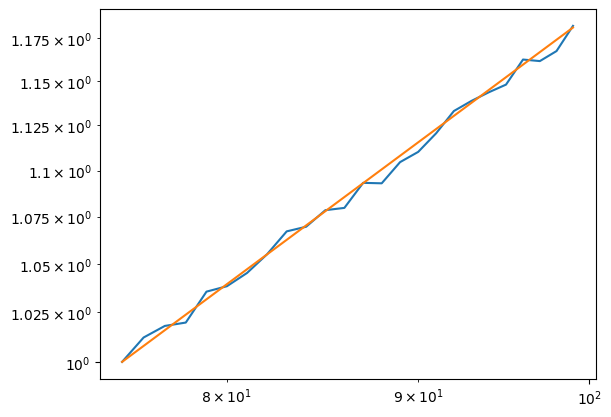

In [206]:
minL = 60
mean_inf = mftp_inf.mean(0)[minL:]
Lsplot = Ls[minL:]
plt.loglog(Lsplot, mean_inf/mean_inf[0])
plt.loglog(Lsplot, (Lsplot/Lsplot[0])**(0.6))

## 2D (not applicable to our case?)

#### Trajectory generator

In [101]:
#| export
def constant_velocity_generator_2D(N, # Number of trajectories
                                   T, # Length of trajectories
                                   time_sampler, # Sampler of time of constant velocity
                                   velocity = 1, # Velocity
                                   **sample_args # Optional arguments for the sampler
                               ):
    ''' Given a sampler for length of time steps, generates a 2D trajectory considering a constant
    velocity in the sampled times. After each time step, we sample a new direction. '''
    
    trajs_x = np.zeros((N, T))
    trajs_y = np.zeros((N, T))
    
    for idxN in (range(N)):        
        
        times = time_sampler(num_samples = T+1, **sample_args).astype(int)
        
        # If we have too many times (e.g. because we sampled big times),
        # we cut the times vector with max_t
        max_t = np.argwhere(np.cumsum(times) > T+1).flatten()
        if len(max_t) > 0:
            max_t = max_t[0]
        else: max_t = T+1
        
        traj_x = np.array([0])
        traj_y = np.array([0])
        cumsum = 0
        for time in times[:max_t+1]:
            angle = np.random.rand()*2*np.pi
            
            segment_x = np.cos(angle)*np.arange(1, min(time+1, T+1))+traj_x[-1]
            segment_y = np.sin(angle)*np.arange(1, min(time+1, T+1))+traj_y[-1]
            
            traj_x = np.append(traj_x, segment_x)
            traj_y = np.append(traj_y, segment_y)
            
            cumsum += len(segment_x)
            if cumsum > T:
                break

        trajs_x[idxN] = traj_x[:T]
        trajs_y[idxN] = traj_y[:T]        
    
    return trajs_x, trajs_y
    

In [73]:
N = 5; T = 150
trajs_lw_x, trajs_lw_y = constant_velocity_generator_2D(N, T, time_sampler = lw_step, beta = 1)

def single_steps(num_samples):
    return np.ones(num_samples)

trajs_rw_x, trajs_rw_y = constant_velocity_generator_2D(N, T, time_sampler = single_steps, velocity = 1.2)


Finished generating trajectories
Finished generating trajectories


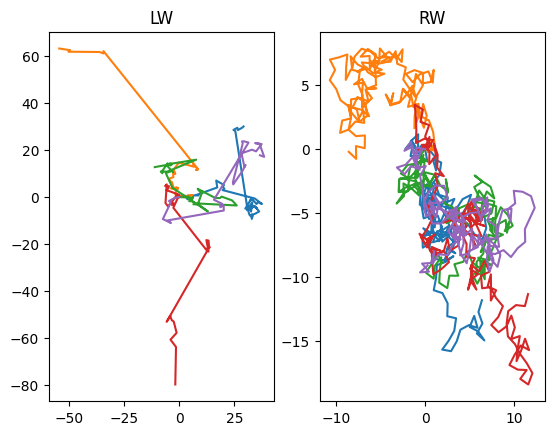

In [81]:
fig, ax = plt.subplots(1, 2)
for x, y in zip(trajs_lw_x, trajs_lw_y):
    ax[0].plot(x, y)
ax[0].set_title('LW')
for x, y in zip(trajs_rw_x, trajs_rw_y):
    ax[1].plot(x, y)
ax[1].set_title('RW');

In [80]:
# Check that displacements are unitary
np.sqrt((x[1:]-x[:-1])**2 + (y[1:]-y[:-1])**2 )

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

#### MFPT calculator

In [177]:
#| export
from typing import Callable

def mfpt_rw_2D(N:int, # Number of trajectories
               T:int, # Lengths of trajectories
               x0:list, # Starting point of walk (in 2d)
               Ls:list, # Boundary position
               traj_generator:Callable,  # Function generating the walk (must start in x0 = zero)
               max_loop = 5,  # Max number of while loop if some walks do not reach the boundary
               **args_generator # Arguments of the trajectory generator
           ): # MFPT vs. L
    ''' Calculates MFPT to boundaries at 0 and L starting in x0 in 2D'''



    # Debug
    # N = 5; T = 50; x0 = [3,3]; Ls = [99]; max_loop = 40

    trajs_x, trajs_y = traj_generator(N, T, **args_generator)
    
    trajs_x += x0[0]
    trajs_y += x0[1]

    mfpt = []
    for L in tqdm_term(Ls):   

        first_passage_x = np.argmax((trajs_x < -L**2) | (trajs_x > L), axis = 1).astype(float)
        first_passage_y = np.argmax((trajs_y < -L**2) | (trajs_y > L), axis = 1).astype(float)

        # Needed transformation to correctly find the minimum considering the presence of zeros
        first_passage_x[first_passage_x == 0] = np.nan
        first_passage_y[first_passage_y == 0] = np.nan    
        first_passage = np.nanmin(np.vstack((first_passage_x, first_passage_y)), axis = 0)
        first_passage[np.isnan(first_passage)] = 0

        # Enlarging the time of those who did not hit the boundaries
        n_loop = 0
        non_passed = np.argwhere(first_passage == 0).flatten()
        last_non_passed = (trajs_x[non_passed, -1], trajs_x[non_passed, -1])    
        while len(non_passed) > 0 and n_loop < max_loop:


            # print('inside')
            trajs_upd_x = rw_generator(len(non_passed),T) + last_non_passed[0][..., np.newaxis]
            trajs_upd_y = rw_generator(len(non_passed),T) + last_non_passed[1][..., np.newaxis]


            # Finding the FPT of the new trajectories
            first_upd_x = np.argmax((trajs_upd_x < -L**2) | (trajs_upd_x > L), axis = 1).astype(float)
            first_upd_y = np.argmax((trajs_upd_y < -L**2) | (trajs_upd_y > L), axis = 1).astype(float)

            # Needed transformation to correctly find the minimum considering the presence of zeros
            first_upd_x[first_upd_x == 0] = np.nan
            first_upd_y[first_upd_y == 0] = np.nan    
            first_upd = np.nanmin(np.vstack((first_upd_x, first_upd_y)), axis = 0)
            first_upd[np.isnan(first_upd)] = 0

            # Adding these to the main FPT array, considering that loop number
            first_passage[non_passed] = (first_upd + (n_loop+1)*T)*first_upd.astype(bool)

            # Checking the ones that still did not pass
            non_passed = np.argwhere(first_passage == 0).flatten()
            # updating the last element of the non passed trajectories
            upd_non_passed = np.argwhere(first_upd == 0).flatten()
            if len(non_passed) != len(upd_non_passed): print('ERROR')
            last_non_passed = (trajs_upd_x[upd_non_passed, -1], trajs_upd_y[upd_non_passed, -1])

            n_loop += 1        

        # Calculating mean considering that some may not have passed              
        first_passage = first_passage[first_passage != 0].mean() 
        if len(non_passed) > 0: print(round(len(non_passed)/len(non_passed),2))
        # Adding this MFPT for current L
        mfpt.append(first_passage)
        
    return mfpt
    

### Discrete walking
In this case we are already doing constant velocities, hence we can use the generator below:

In [178]:
N = int(1e4)
T = int(1e2)
x0 = [1, 1]
Ls = np.linspace(5, 150, 20)

reps = 10
results = np.array(Parallel(n_jobs=10)(delayed(mfpt_rw_2D)(N = N, T = T, x0 = x0, Ls = Ls, 
                                                           traj_generator = constant_velocity_generator_2D,
                                                           time_sampler = single_steps)
                for _ in tqdm(range(reps))), dtype = object)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_211465/3611285207.py:33: RuntimeWarning: All-NaN slice encountered
/tmp/ipykernel_211465/3611285207.py:55: RuntimeWarning: All-NaN slice encountered
  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_211465/3611285207.py:33: RuntimeWarning: All-NaN slice encountered
/tmp/ipykernel_211465/3611285207.py:55: RuntimeWarning: All-NaN slice encountered
  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_211465/3611285207.py:33: RuntimeWarning: All-NaN slice encountered
/tmp/ipykernel_211465/3611285207.py:55: RuntimeWarning: All-NaN slice encountered
  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_211465/3611285207.py:33: RuntimeWarning: All-NaN slice encountered
/tmp/ipykernel_211465/3611285207.py:55: RuntimeWarning: All-NaN slice encountered
  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_211465/3611285207.py:55: RuntimeWarning: All-NaN slice encountered
/tmp/ipykernel_211465/3611285207.py:33: RuntimeWarning: All-NaN slice en

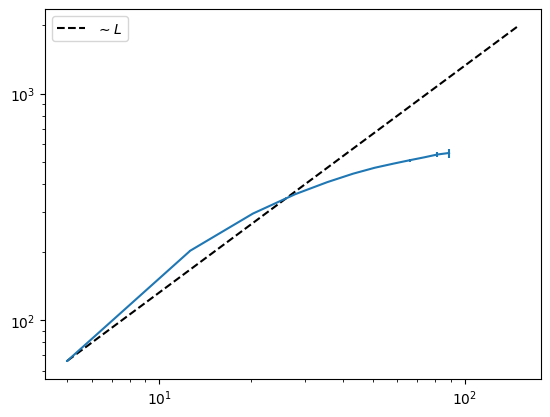

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [179]:
mean = results.mean(0)


# plt.plot(Ls, mean[0]*(Ls/Ls[0])**(1/2),c = 'k', label = r'$\sim L^{1/2}$')
plt.loglog(Ls, mean[0]*(Ls/Ls[0]), c = 'k',ls = '--', label = r'$\sim L$')
# plt.loglog(Ls, mean,'o', alpha = 0.8)
plt.errorbar(Ls, mean, yerr = results.astype(float).std(0))

plt.legend()

# plt.xlim(xmax = 150)

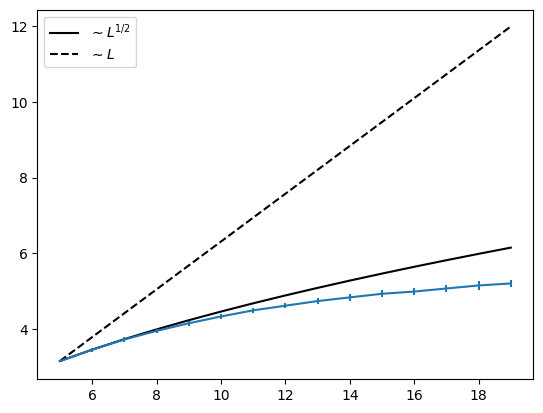

In [164]:
mean = results.mean(0)


plt.plot(Ls, mean[0]*(Ls/Ls[0])**(1/2),c = 'k', label = r'$\sim L^{1/2}$')
plt.plot(Ls, mean[0]*(Ls/Ls[0]), c = 'k',ls = '--', label = r'$\sim L$')
# plt.loglog(Ls, mean,'o', alpha = 0.8)
plt.errorbar(Ls, mean, yerr = results.astype(float).std(0))

plt.legend()

# plt.xlim(xmax = 150)

### Exponential

In [116]:
N = int(1e2)
T = int(1e4)
x0 = [0.5, 0.5]
Ls = np.arange(15, 100)

reps = 20
results = np.array(Parallel(n_jobs=20)(delayed(mfpt_rw_2D)(N = N, T = T, x0 = x0, Ls = Ls,
                                                           traj_generator = constant_velocity_generator_2D,
                                                           time_sampler = exp_time_generator)
                for _ in tqdm(range(reps))), dtype = object)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 85/85 [00:00<00:00, 862.26it/s]


Text(0.5, 1.0, '$x_0 =$ [0.5, 0.5]')

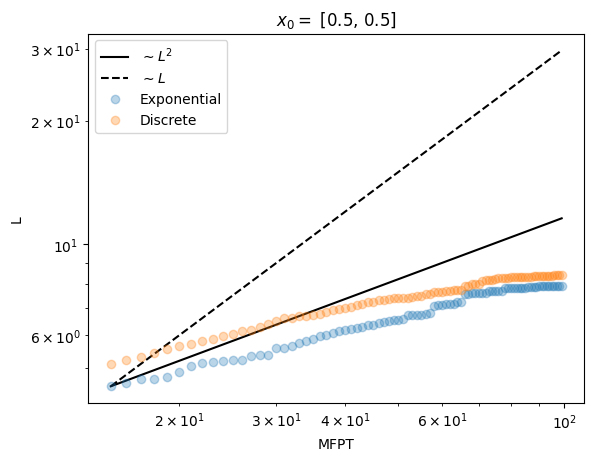

In [119]:
mean_exp = results.mean(0)

plt.plot(Ls, mean_exp[0]*(Ls/Ls[0])**(1/2),c = 'k', label = r'$\sim L^2$')
plt.plot(Ls, mean_exp[0]*(Ls/Ls[0]), c = 'k',ls = '--', label = r'$\sim L$')
plt.loglog(Ls, mean_exp,'o', alpha = 0.3, label = 'Exponential')
plt.loglog(Ls, mean,'o', alpha = 0.3, label = 'Discrete')
plt.legend()
plt.xlabel('MFPT'); plt.ylabel('L'); plt.title(fr'$x_0 =$ {x0}') 

### Biexponential

#### Uninformed

In [138]:
N = int(1e3)
T = int(1e5)
x0 = [0.5, 0.5]
Ls = np.arange(5, 30)

reps = 20*4
results = np.array(Parallel(n_jobs=5)(delayed(mfpt_rw_2D)(N = N, T = T, x0 = x0, Ls = Ls,
                                                        traj_generator = constant_velocity_generator_2D,
                                                        time_sampler = biexp_time_generator, w1 = 0.5, d1 = 1, d2 = 5)
                for _ in tqdm(range(reps))), dtype = object)

mean_uninf_biexp = results.mean(0)


  0%|          | 0/80 [00:00<?, ?it/s]

KeyboardInterrupt: 

Text(0.5, 1.0, '$x_0 =$ [0.5, 0.5]')

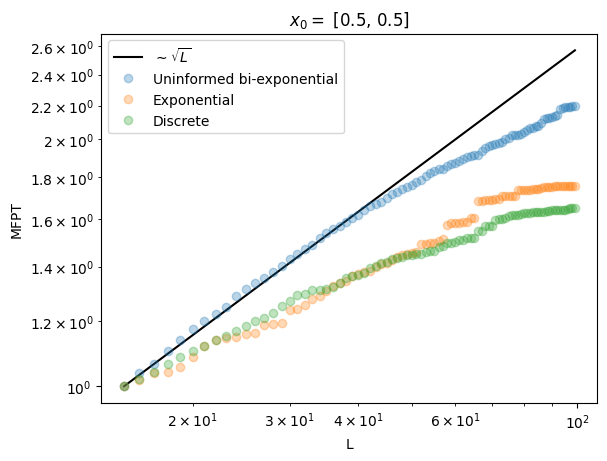

In [137]:

plt.plot(Ls, (Ls/Ls[0])**(1/2),c = 'k', label = r'$\sim \sqrt{L}$')
# plt.plot(Ls, (Ls/Ls[0]), c = 'k',ls = '--', label = r'$\sim L$')

plt.loglog(Ls, mean_uninf_biexp/mean_uninf_biexp[0],'o', alpha = 0.3, label = 'Uninformed bi-exponential')
plt.loglog(Ls, mean_exp/mean_exp[0],'o', alpha = 0.3, label = 'Exponential')
plt.loglog(Ls, mean/mean[0],'o', alpha = 0.3, label = 'Discrete')
plt.legend()
plt.ylabel('MFPT'); plt.xlabel('L'); plt.title(fr'$x_0 =$ {x0}') 

Text(0.5, 1.0, '$x_0 =$ [0.5, 0.5]')

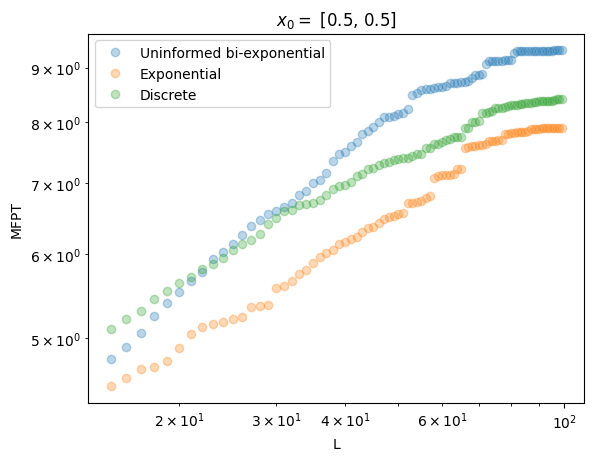

In [131]:
plt.loglog(Ls, mean_uninf_biexp,'o', alpha = 0.3, label = 'Uninformed bi-exponential')
plt.loglog(Ls, mean_exp,'o', alpha = 0.3, label = 'Exponential')
plt.loglog(Ls, mean,'o', alpha = 0.3, label = 'Discrete')
plt.legend()
plt.ylabel('MFPT'); plt.xlabel('L'); plt.title(fr'$x_0 =$ {x0}') 

#### Informed

In [124]:
#| export
from typing import Callable

def mfpt_informed_rw_2D(N:int, # Number of trajectories
                        T:int, # Lengths of trajectories
                        x0:list, # Starting point of walk (in 2d)
                        Ls:list, # Boundary position
                        traj_generator:Callable,  # Function generating the walk (must start in x0 = zero)
                        max_loop = 5,  # Max number of while loop if some walks do not reach the boundary
                        **args_generator # Arguments of the trajectory generator
                       ): # MFPT vs. L
    ''' Calculates MFPT to boundaries at 0 and L starting in x0 in 2D'''



    # Debug
    # N = 5; T = 50; x0 = [3,3]; Ls = [99]; max_loop = 40


    mfpt = []
    for L in tqdm_term(Ls):   
        
        
        trajs_x, trajs_y = traj_generator(N, T, time_sampler = time_sampler, x0 = x0, L = L, informed = True)        
        trajs_x += x0[0]
        trajs_y += x0[1]

        first_passage_x = np.argmax((trajs_x < 0) | (trajs_x > L), axis = 1).astype(float)
        first_passage_y = np.argmax((trajs_y < 0) | (trajs_y > L), axis = 1).astype(float)

        # Needed transformation to correctly find the minimum considering the presence of zeros
        first_passage_x[first_passage_x == 0] = np.nan
        first_passage_y[first_passage_y == 0] = np.nan    
        first_passage = np.nanmin(np.vstack((first_passage_x, first_passage_y)), axis = 0)
        first_passage[np.isnan(first_passage)] = 0

        # Enlarging the time of those who did not hit the boundaries
        n_loop = 0
        non_passed = np.argwhere(first_passage == 0).flatten()
        last_non_passed = (trajs_x[non_passed, -1], trajs_x[non_passed, -1])    
        while len(non_passed) > 0 and n_loop < max_loop:


            # print('inside')
            trajs_upd_x = rw_generator(len(non_passed),T) + last_non_passed[0][..., np.newaxis]
            trajs_upd_y = rw_generator(len(non_passed),T) + last_non_passed[1][..., np.newaxis]


            # Finding the FPT of the new trajectories
            first_upd_x = np.argmax((trajs_upd_x < 0) | (trajs_upd_x > L), axis = 1).astype(float)
            first_upd_y = np.argmax((trajs_upd_y < 0) | (trajs_upd_y > L), axis = 1).astype(float)

            # Needed transformation to correctly find the minimum considering the presence of zeros
            first_upd_x[first_upd_x == 0] = np.nan
            first_upd_y[first_upd_y == 0] = np.nan    
            first_upd = np.nanmin(np.vstack((first_upd_x, first_upd_y)), axis = 0)
            first_upd[np.isnan(first_upd)] = 0

            # Adding these to the main FPT array, considering that loop number
            first_passage[non_passed] = (first_upd + (n_loop+1)*T)*first_upd.astype(bool)

            # Checking the ones that still did not pass
            non_passed = np.argwhere(first_passage == 0).flatten()
            # updating the last element of the non passed trajectories
            upd_non_passed = np.argwhere(first_upd == 0).flatten()
            if len(non_passed) != len(upd_non_passed): print('ERROR')
            last_non_passed = (trajs_upd_x[upd_non_passed, -1], trajs_upd_y[upd_non_passed, -1])

            n_loop += 1        

        # Calculating mean considering that some may not have passed              
        first_passage = first_passage[first_passage != 0].mean() 
        # Adding this MFPT for current L
        mfpt.append(first_passage)
        
    return mfpt
    

In [ ]:
N = int(1e2)
T = int(1e4)
x0 = 3
Ls = np.arange(15, 100)

reps = 20
results = np.array(Parallel(n_jobs=10)(delayed(mfpt_informed_rw)(N = N, T = T, x0 = x0, Ls = Ls, 
                                                                 traj_generator = constant_velocity_generator,
                                                                 time_sampler = biexp_time_generator)
                for _ in tqdm(range(reps))), dtype = object)

mean_biexp = results.mean(0)

In [ ]:
plt.plot(Ls, (Ls/Ls[0])**(1/2),c = 'k', label = r'$\sim \sqrt{L}$')
plt.plot(Ls, (Ls/Ls[0]), c = 'k',ls = '--', label = r'$\sim L$')


plt.loglog(Ls, mean_biexp/mean_biexp[0],'o', alpha = 0.3, label = 'Informed bi-exponential')
plt.loglog(Ls, mean_uninf_biexp/mean_uninf_biexp[0],'o', alpha = 0.3, label = 'Uninformed bi-exponential')
plt.loglog(Ls, mean_exp/mean_exp[0],'o', alpha = 0.3, label = 'Exponential')
plt.loglog(Ls, mean/mean[0],'o', alpha = 0.3, label = 'Discrete')
plt.legend()
plt.ylabel('MFPT'); plt.xlabel('L'); plt.title(fr'$x_0 =$ {x0}') 

### Power-law

In [127]:
N = int(1e3)
T = int(1e4)
x0 = [0.5, 0.5]
Ls = np.arange(15, 100)

reps = 20
beta = 1

results = np.array(Parallel(n_jobs=20)(delayed(mfpt_rw_2D)(N = N, T = T, x0 = x0, Ls = Ls, 
                                                        traj_generator = constant_velocity_generator_2D,
                                                        time_sampler = lw_step, beta = beta)
                for _ in tqdm(range(reps))), dtype = object)

mean_pw = results.mean(0)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 85/85 [00:09<00:00,  8.58it/s]


[Text(0, 0.5, 'MFPT'),
 Text(0.5, 0, 'L'),
 Text(0.5, 1.0, '$x_0 =$ [0.5, 0.5]'),
 Text(0, 0.5, 'MFPT'),
 Text(0.5, 0, 'L'),
 Text(0.5, 1.0, '$x_0 =$ [0.5, 0.5]')]

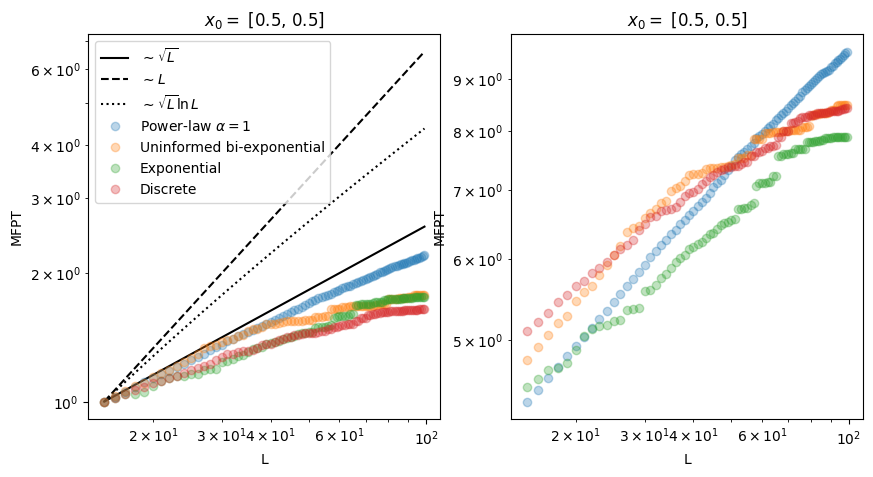

In [128]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

ax[0].plot(Ls, (Ls/Ls[0])**(1/2),c = 'k', label = r'$\sim \sqrt{L}$')
ax[0].plot(Ls, (Ls/Ls[0]), c = 'k',ls = '--', label = r'$\sim L$')
pw_scaling = np.log(Ls)*Ls**(1/2)
ax[0].plot(Ls, pw_scaling/pw_scaling[0], c = 'k',ls = ':', label = r'$\sim \sqrt{L}\ln{L}$')

ax[0].loglog(Ls, mean_pw/mean_pw[0],' o', alpha = 0.3, label = r'Power-law $\alpha = 1$')
# ax[0].loglog(Ls, mean_biexp/mean_biexp[0],'o', alpha = 0.3, label = 'Informed bi-exponential')
ax[0].loglog(Ls, mean_uninf_biexp/mean_uninf_biexp[0],'o', alpha = 0.3, label = 'Uninformed bi-exponential')
ax[0].loglog(Ls, mean_exp/mean_exp[0],'o', alpha = 0.3, label = 'Exponential')
ax[0].loglog(Ls, mean/mean[0],'o', alpha = 0.3, label = 'Discrete')
ax[0].legend()


ax[1].loglog(Ls, mean_pw,' o', alpha = 0.3, label = r'Power-law $\alpha = 1$')
# ax[1].loglog(Ls, mean_biexp,'o', alpha = 0.3, label = 'Informed bi-exponential')
ax[1].loglog(Ls, mean_uninf_biexp,'o', alpha = 0.3, label = 'Uninformed bi-exponential')
ax[1].loglog(Ls, mean_exp,'o', alpha = 0.3, label = 'Exponential')
ax[1].loglog(Ls, mean,'o', alpha = 0.3, label = 'Discrete')



plt.setp(ax, ylabel = 'MFPT', xlabel = 'L', title = fr'$x_0 =$ {x0}') 
                    

# NBDEV Export

In [13]:
from nbdev import nbdev_export; nbdev_export()